/cbica/home/dadashkj/.conda/envs/pushkar/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


before cwd: /gpfs/fs001/cbica/home/dadashkj/eeg/startkit/pushkar
after  cwd: /gpfs/fs001/cbica/home/dadashkj/eeg/startkit/pushkar
cwd: /gpfs/fs001/cbica/home/dadashkj/eeg/startkit/pushkar
Using BASE_DIRS:
   data/2017-1/Batch 1
   data/2017-1/Batch 2
[scan] data/2017-1/Batch 1 -> pairs=3
[scan] data/2017-1/Batch 2 -> pairs=15
TOTAL PAIRS: 18

[example pairs]
  idx=1 folder=data/2017-1/Batch 1
     unann: IMAGE 1 unannotated.tif
     ann  : IMAGE 1 annotated_FLAT.tif
  idx=2 folder=data/2017-1/Batch 1
     unann: IMAGE 2 unannotated.tif
     ann  : IMAGE 2 annotated_FLAT.tif
  idx=3 folder=data/2017-1/Batch 1
     unann: IMAGE 3 unannotated.tif
     ann  : IMAGE 3 annotated_FLAT.tif

EXP_DIR: segformer-rerun-equal-epochs/E1Round1/PushkarA07_segformer-b0-finetuned-net-15Oct
Latest checkpoint: segformer-rerun-equal-epochs/E1Round1/PushkarA07_segformer-b0-finetuned-net-15Oct/checkpoint-434400 step: 434400
device: cuda


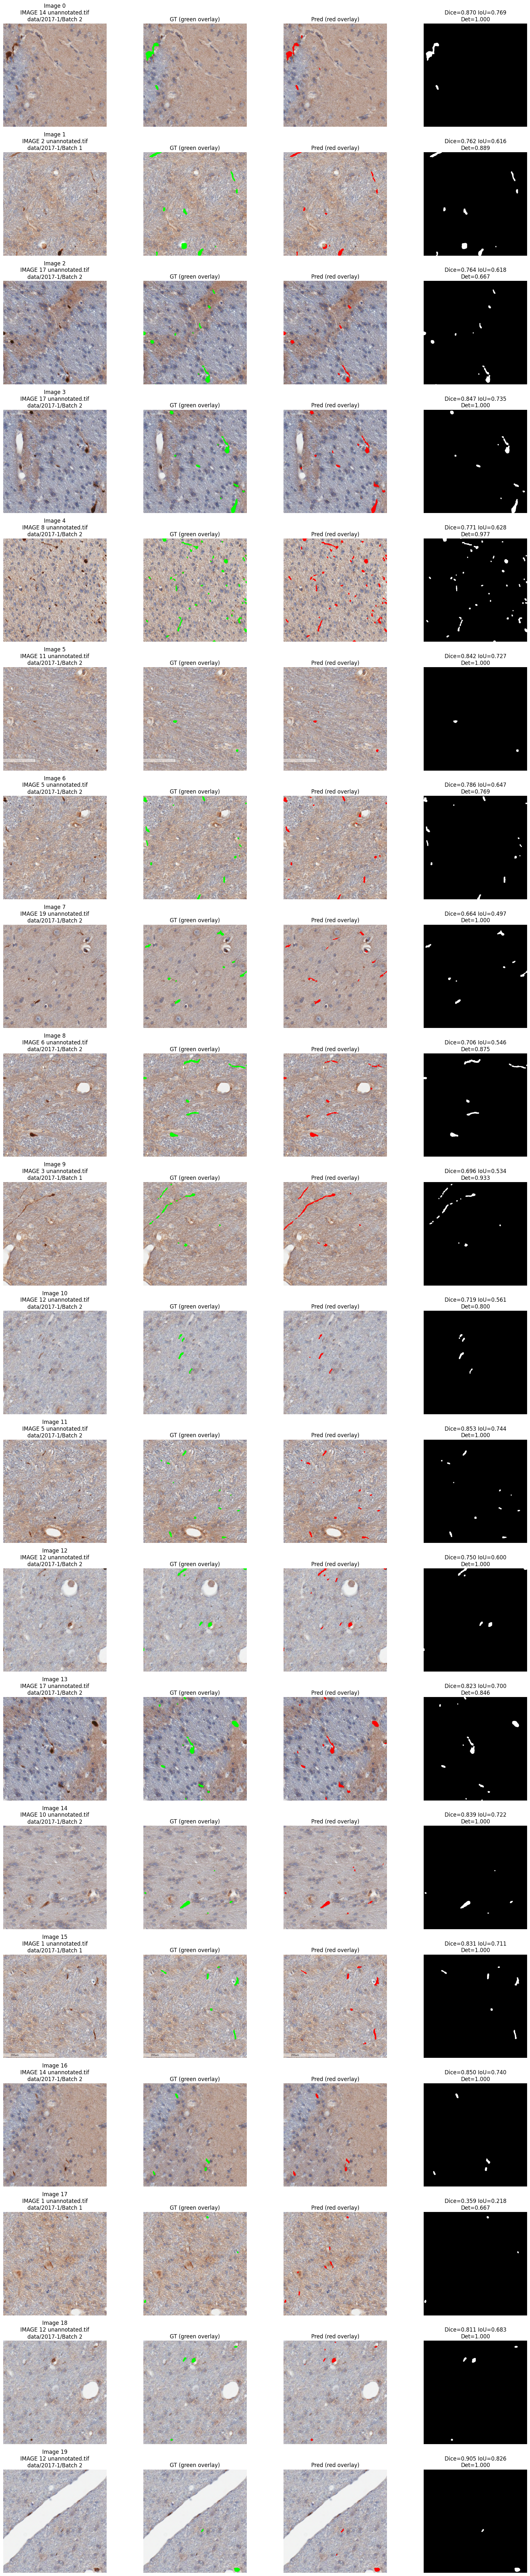


===== SUMMARY =====
N used: 25
Mean Dice: 0.7731540954514549
Mean IoU : 0.6403724808932252
Mean Det : 0.9194258927979858


In [1]:
# ONE CELL: load latest checkpoint under EXP_DIR + test on local TIFF folders (BASE_DIRS)
# - robust checkpoint finder (by largest checkpoint-N, recursive)
# - robust TIFF pairing for BOTH styles:
#     2016: "Image 6 unannotated.tif" + "Image 6_FLAT.tif"
#     2017: "IMAGE 13 unannotated.tif" + "IMAGE 13 annotated_FLAT.tif"
# - prints proof of which folder/files were sampled
# - overlays: GT green, Pred red

import os, re, random
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import tifffile as tiff
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor

import os

print("before cwd:", os.getcwd())
os.chdir("/gpfs/fs001/cbica/home/dadashkj/eeg/startkit/pushkar")  # <-- adjust if needed
print("after  cwd:", os.getcwd())

# ============== EDIT THESE ONLY ==============
EXP_DIR = "segformer-rerun-equal-epochs/E1Round1/PushkarA07_segformer-b0-finetuned-net-15Oct"
# EXP_DIR = "segformer-rerun-equal-epochs/E1Round2/PushkarA07_segformer-b0-finetuned-net-15Oct"
# EXP_DIR = "segformer-rerun-equal-epochs/E1Round3/PushkarA07_segformer-b0-finetuned-net-15Oct"
# EXP_DIR = "segformer-rerun-equal-epochs/Exp3_norm/PushkarA07_segformer-b0-finetuned-net-15Oct"
# EXP_DIR = "segformer-rerun-equal-epochs/Exp3_unnorm/PushkarA07_segformer-b0-finetuned-net-15Oct"

BASE_DIRS = [
    "data/2017-1/Batch 1",
    "data/2017-1/Batch 2",
]
# BASE_DIRS = [
#     "data/2016-5 and 2016-6/Batch 3/2016-5/2016-5 A2",
#     "data/2016-5 and 2016-6/Batch 3/2016-6/2016-6 P2",
# ]

N_SAMPLES = 25
PATCH = 512
MIN_MASK_PIXELS = 10
MIN_CC_AREA = 5
SEED = 0
# ============================================

IGNORE = 255

if SEED is not None:
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)

def find_latest_checkpoint_recursive(root: str):
    best_step, best_path = -1, None
    if not os.path.isdir(root):
        return None, None
    for dirpath, dirnames, _ in os.walk(root):
        for d in dirnames:
            m = re.match(r"checkpoint-(\d+)$", d)
            if not m:
                continue
            step = int(m.group(1))
            p = os.path.join(dirpath, d)
            if step > best_step:
                best_step, best_path = step, p
    return best_path, best_step

def list_pairs(folder):
    files = [f for f in os.listdir(folder) if f.lower().endswith((".tif", ".tiff"))]
    unann, ann = {}, {}

    for f in files:
        fn = f.strip()

        # unannotated: "Image 6 unannotated.tif"
        m_un = re.match(r"image\s*(\d+)\s*unannotated\.tif(f)?$", fn, flags=re.IGNORECASE)

        # annotated (2016): "Image 6_FLAT.tif"
        m_a16 = re.match(r"image\s*(\d+)_flat\.tif(f)?$", fn, flags=re.IGNORECASE)

        # annotated (2017): "IMAGE 13 annotated_FLAT.tif"
        m_a17 = re.match(r"image\s*(\d+)\s*annotated_flat\.tif(f)?$", fn, flags=re.IGNORECASE)

        if m_un:
            unann[int(m_un.group(1))] = os.path.join(folder, f)
        if m_a16:
            ann[int(m_a16.group(1))] = os.path.join(folder, f)
        if m_a17:
            ann[int(m_a17.group(1))] = os.path.join(folder, f)

    keys = sorted(set(unann.keys()) & set(ann.keys()))
    return [(k, unann[k], ann[k]) for k in keys]

def list_pairs_multi(folders):
    all_pairs = []
    for fd in folders:
        if not os.path.isdir(fd):
            print("WARN: missing folder:", fd)
            continue
        pairs = list_pairs(fd)
        print(f"[scan] {fd} -> pairs={len(pairs)}")
        all_pairs.extend(pairs)
    return all_pairs

def read_tif_rgb(path):
    img = tiff.imread(path)
    if img.ndim == 3 and img.shape[0] in (3, 4) and img.shape[-1] not in (3, 4):
        img = np.transpose(img, (1, 2, 0))
    if img.ndim == 2:
        img = np.stack([img]*3, axis=-1)
    if img.shape[-1] == 4:
        img = img[..., :3]
    if img.dtype != np.uint8:
        imin, imax = float(img.min()), float(img.max())
        img = (255.0 * (img - imin) / (imax - imin)).astype(np.uint8) if imax > imin else np.zeros_like(img, dtype=np.uint8)
    return img

def green_mask_from_annotated_rgb(ann_rgb):
    hsv = cv2.cvtColor(ann_rgb, cv2.COLOR_RGB2HSV)
    lower = np.array([35, 120, 60], dtype=np.uint8)
    upper = np.array([85, 255, 255], dtype=np.uint8)
    m = cv2.inRange(hsv, lower, upper)
    m = cv2.medianBlur(m, 5)
    m = cv2.morphologyEx(m, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=1)
    m = cv2.morphologyEx(m, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8), iterations=2)
    m = cv2.dilate(m, np.ones((3, 3), np.uint8), iterations=1)
    return (m > 0).astype(np.uint8)

def dice_iou_binary(gt, pr, eps=1e-7):
    gt = (gt > 0).astype(np.uint8)
    pr = (pr > 0).astype(np.uint8)
    inter = (gt & pr).sum()
    union = gt.sum() + pr.sum() - inter
    dice = (2*inter + eps) / (gt.sum() + pr.sum() + eps)
    iou  = (inter + eps) / (union + eps)
    return float(dice), float(iou)

def cluster_detection_rate(gt, pr, min_cc_area=1):
    gt = (gt > 0).astype(np.uint8)
    pr = (pr > 0).astype(np.uint8)
    nlabels, labels = cv2.connectedComponents(gt, connectivity=8)
    total, detected = 0, 0
    for lab in range(1, nlabels):
        cc = (labels == lab)
        if cc.sum() < min_cc_area:
            continue
        total += 1
        if (pr[cc] > 0).any():
            detected += 1
    return detected/total if total > 0 else np.nan

# ----------------- PROOF / SANITY -----------------
print("cwd:", os.getcwd())
print("Using BASE_DIRS:")
for d in BASE_DIRS:
    print("  ", d)

pairs = list_pairs_multi(BASE_DIRS)
print("TOTAL PAIRS:", len(pairs))
assert len(pairs) > 0, "No TIFF pairs found. Your BASE_DIRS paths or filename patterns don't match."

# show a few pairs as proof
print("\n[example pairs]")
for i in range(min(3, len(pairs))):
    k, u, a = pairs[i]
    print(f"  idx={k} folder={os.path.dirname(u)}")
    print("     unann:", os.path.basename(u))
    print("     ann  :", os.path.basename(a))

CKPT_DIR, CKPT_STEP = find_latest_checkpoint_recursive(EXP_DIR)
print("\nEXP_DIR:", EXP_DIR)
print("Latest checkpoint:", CKPT_DIR, "step:", CKPT_STEP)
assert CKPT_DIR is not None, f"No checkpoint-* found under {EXP_DIR}. (Path wrong or not visible from cwd)"

# ----------------- MODEL -----------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

processor = SegformerImageProcessor(do_resize=True, do_normalize=True)
model = SegformerForSemanticSegmentation.from_pretrained(CKPT_DIR).to(device)
model.eval()

# ----------------- TEST LOOP -----------------
all_dice, all_iou, all_det = [], [], []

MAX_PLOT = min(N_SAMPLES, 20)
plt.figure(figsize=(18, 4*MAX_PLOT))

for k in range(N_SAMPLES):
    idx, unann_path, ann_path = random.choice(pairs)

    unann = read_tif_rgb(unann_path)
    ann   = read_tif_rgb(ann_path)
    gt_full = green_mask_from_annotated_rgb(ann)

    # resize gt if needed
    if gt_full.shape[:2] != unann.shape[:2]:
        gt_full = cv2.resize(gt_full, (unann.shape[1], unann.shape[0]), interpolation=cv2.INTER_NEAREST)

    H, W = unann.shape[:2]
    if H < PATCH or W < PATCH:
        continue

    # choose patch (prefer positive)
    x = y = 0
    for _ in range(80):
        x = random.randint(0, W - PATCH)
        y = random.randint(0, H - PATCH)
        if int(gt_full[y:y+PATCH, x:x+PATCH].sum()) > MIN_MASK_PIXELS:
            break

    img = unann[y:y+PATCH, x:x+PATCH].copy()
    gt  = gt_full[y:y+PATCH, x:x+PATCH].copy().astype(np.uint8)

    inputs = processor(images=[img], return_tensors="pt").to(device)
    with torch.no_grad():
        logits = model(**inputs).logits

    pred = torch.nn.functional.interpolate(
        logits, size=gt.shape, mode="bilinear", align_corners=False
    ).argmax(dim=1)[0].cpu().numpy()

    dice, iou = dice_iou_binary(gt, pred)
    det = cluster_detection_rate(gt, pred, MIN_CC_AREA)

    all_dice.append(dice)
    all_iou.append(iou)
    all_det.append(det)

    # ---- plots (proof of which dataset) ----
    if k < MAX_PLOT:
        overlay_gt = img.copy()
        overlay_gt[gt > 0] = (0, 255, 0)      # GT green

        overlay_pred = img.copy()
        overlay_pred[pred == 1] = (255, 0, 0) # Pred red

        plt.subplot(MAX_PLOT, 4, 4*k+1)
        plt.imshow(img); plt.axis("off")
        plt.title(f"Image {k}\n{os.path.basename(unann_path)}\n{os.path.dirname(unann_path)}")

        plt.subplot(MAX_PLOT, 4, 4*k+2)
        plt.imshow(overlay_gt); plt.axis("off")
        plt.title("GT (green overlay)")

        plt.subplot(MAX_PLOT, 4, 4*k+3)
        plt.imshow(overlay_pred); plt.axis("off")
        plt.title("Pred (red overlay)")

        plt.subplot(MAX_PLOT, 4, 4*k+4)
        plt.imshow(gt, cmap="gray"); plt.axis("off")
        plt.title(f"Dice={dice:.3f} IoU={iou:.3f}\nDet={det:.3f}")

plt.tight_layout()
plt.show()

print("\n===== SUMMARY =====")
print("N used:", len(all_dice))
print("Mean Dice:", float(np.nanmean(all_dice)))
print("Mean IoU :", float(np.nanmean(all_iou)))
print("Mean Det :", float(np.nanmean(all_det)))
